# 1D Variability hypothesis testing for lupus data

In [1]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from pybedtools import BedTool
import pickle as pkl
%matplotlib inline

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq/')
import encode
import memento

In [4]:
data_path = '/data_volume/memento/lupus/'

### Read the processed RNA data

Focus on the club and bc/club cells and type I interferons for now.

Encode the timestamps to integers.

In [39]:
adata = sc.read(data_path + 'cM_sampled.h5ad')

In [40]:
adata

AnnData object with n_obs × n_vars = 17683 × 32738
    obs: 'BatchL0_x', 'BatchL1_x', 'BatchL2_x', 'BatchL3_x', 'Prob(doublet)', 'age', 'batch', 'batch_cov', 'disease_cov', 'ind_cov', 'pop_cov', 'sex', 'study', 'Genotype ID', 'Old Genotype ID', 'Study_ID', 'Status', 'Age', 'Sex', 'Ethnicity', 'Study', 'BatchL0_y', 'BatchL1_y', 'BatchL2_y', 'BatchL3_y', 'Vicell', 'Cells Collected', 'Tubes', 'Concentration', 'Unnamed: 16', 'Processing_Cohort', 'n_genes', 'platelet', 'rbc', 'louvain', 'ct_cov', 'cg_cov', 'ind_cov_pop_cov', 'pop_cov_disease_cov', 'ind_cov_pop_cov_cohort', 'pop_cov_cohort_disease_cov', 'ind_cov_batch_cov', 'pop_cov_SLE_status', 'pop_cov_cohort_SLE_status', 'SLE_status', 'ind_cov_cohort', 'umap_density_disease_cov', 'umap_density_SLE_status', 'umap_density_pop_cov_SLE_status'
    var: 'gene_ids', 'feature_types-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0'

### Setup memento

In [41]:
adata.obs['q'] = 0.07

In [42]:
memento.setup_memento(adata, q_column='q', trim_percent=0.05)

Version 0.0.6


### Run memento for each subset, comparing beta to gamma, separate cell types

In [43]:
adata.obs['is_sle'] = (adata.obs['SLE_status'] == "SLE").astype(int)

In [44]:
memento.create_groups(adata, label_columns=['is_sle', 'ind_cov'])
memento.compute_1d_moments(adata, min_perc_group=.9)

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [45]:
memento.ht_1d_moments(
    adata, 
    formula_like='1 + is_sle',
    treatment_col='is_sle', 
    num_boot=10000, 
    verbose=1,
    num_cpus=93,
    resampling='permutation',
    approx=True)

[Parallel(n_jobs=93)]: Using backend LokyBackend with 93 concurrent workers.
[Parallel(n_jobs=93)]: Done  14 tasks      | elapsed:    3.7s
[Parallel(n_jobs=93)]: Done 264 tasks      | elapsed:    4.7s
[Parallel(n_jobs=93)]: Done 614 tasks      | elapsed:    6.1s
[Parallel(n_jobs=93)]: Done 1064 tasks      | elapsed:    8.3s
[Parallel(n_jobs=93)]: Done 1614 tasks      | elapsed:   10.5s
[Parallel(n_jobs=93)]: Done 2331 out of 2331 | elapsed:   15.5s finished


In [46]:
df = memento.get_1d_ht_result(adata)

In [47]:
df['de_fdr'] = memento.util._fdrcorrect(df['de_pval'])
df['dv_fdr'] = memento.util._fdrcorrect(df['dv_pval'])

Text(0, 0.5, 'DV Lupus')

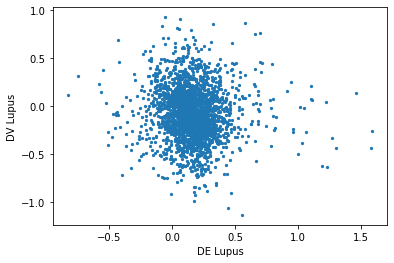

In [48]:
plt.scatter(df['de_coef'], df['dv_coef'], s=5)
plt.xlabel('DE Lupus'); plt.ylabel('DV Lupus')

In [49]:
df.query('dv_fdr < 0.1').sort_values('de_coef', ascending=False).head(50)

,gene,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,de_fdr,dv_fdr
102,IFI44L,1.588194,0.028693,0.000000e+00,-0.263235,0.070900,2.050135e-04,0.000000e+00,5.251499e-03
1252,IFITM3,1.580892,0.019837,0.000000e+00,-0.435923,0.031922,1.867215e-42,0.000000e+00,6.217826e-40
0,ISG15,1.302083,0.024740,0.000000e+00,-0.433264,0.148760,3.585431e-03,0.000000e+00,5.685469e-02
2267,APOBEC3A,1.267284,0.030533,0.000000e+00,-0.335683,0.086339,1.010872e-04,0.000000e+00,2.805169e-03
45,IFI6,1.233130,0.021234,0.000000e+00,-0.638771,0.042977,5.729460e-50,0.000000e+00,2.671074e-47
1083,LY6E,1.190624,0.018230,0.000000e+00,-0.626608,0.039396,5.806661e-57,0.000000e+00,3.383832e-54
2309,MX1,1.030209,0.038957,4.215284e-154,-0.389625,0.136738,4.379732e-03,2.047047e-152,6.461491e-02
1834,XAF1,1.002217,0.039499,4.987312e-142,-0.500240,0.148788,7.735357e-04,2.075969e-140,1.626170e-02
111,GBP2,0.794255,0.041900,3.953814e-80,0.443145,0.141684,1.761795e-03,8.014210e-79,3.259321e-02
752,HLA-DRB5,0.783833,0.025656,5.453200e-205,-0.416697,0.058569,1.121823e-12,3.851942e-203,9.685075e-11


In [22]:
df.query('de_fdr < 0.05')

,gene,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,de_fdr,dv_fdr
0,ISG15,1.110351,0.025223,0.000000e+00,-0.529173,0.136226,1.025301e-04,0.000000e+00,2.451401e-03
1,AURKAIP1,0.253128,0.028883,1.887425e-18,0.136471,0.488875,7.801268e-01,5.732020e-18,9.233724e-01
2,SSU72,0.191334,0.031461,1.189363e-09,0.070564,0.305568,8.173709e-01,2.348368e-09,9.354593e-01
3,GNB1,0.097745,0.042675,2.199550e-02,-0.298193,0.308163,3.332203e-01,2.759932e-02,6.825307e-01
5,RER1,0.199446,0.039033,3.226382e-07,-0.281013,0.347185,4.182833e-01,5.656924e-07,7.419279e-01
...,...,...,...,...,...,...,...,...,...
1309,MT-CO3,-0.183847,0.009437,1.608298e-84,0.337128,0.058733,9.468017e-09,2.073443e-83,6.916913e-07
1310,MT-ND3,-0.144006,0.010320,2.955426e-44,0.057923,0.056517,3.054218e-01,1.952957e-43,6.594905e-01
1311,MT-ND4L,0.064584,0.022136,3.527526e-03,0.207811,0.108691,5.588401e-02,4.704561e-03,2.693186e-01
1312,MT-ND4,-0.057147,0.011087,2.546134e-07,0.087143,0.047818,6.839967e-02,4.470182e-07,3.018308e-01
